### Environment: Minority Game
#### O. Osoba
#### Date: Jan-2019
Exploring implementation of minority game with N players. <br> 
Issues: <br>
- Appropriate decomposition of agent<->env<br>
- Demo'ing: <br>
    - basic minority game
    - 1-vs.-(N-1)
    - k-vs.-(N-k)
    - RF on 1-v-(N-1) mingame
- Differences between std agent adaptation and REINFORCE adaptation? <br>

## Preamble: Libs + signal def

In [1]:
import importlib, sys, warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,7)

warnings.filterwarnings("ignore")

log_path = './log/mingame'
#tensorboard --logdir=mingame_worker_1:'./log/train_rf_mingame_worker'

Tensorflow version: 1.13.1


## Basic MinGame env

In [ ]:
import minoritygame.minority_base as MGA
importlib.reload(MGA)
basegame = MGA.MinorityGame(nagents=301, m=2, s=2, mrl=3, p=0.5)
print(basegame.step())

MGA.repro_fig_1()

# acts = basegame.step()[0]
# print(acts, np.mean(acts))
# Counter(acts).most_common()[-1][0]

## 1-vs-(N-1) Mingame Env

In [ ]:
import minoritygame.minority_env as MGE
importlib.reload(MGE) 

mingame = MGE.MinorityGame1vN_env(nagents=33, m=3, s=4)

In [ ]:
tmp = mingame.stepAll()
print(Counter(tmp[1]).most_common()[-1][0], tmp[-1])
print(tmp)

## k-vs-(N-k) Mingame Env

In [47]:
import minoritygame.minority_multienv as MGME
importlib.reload(MGME) 

## Init
n_ag = 51
exos = (np.random.sample(n_ag) < 0.3)
n_rl = np.sum(exos)
multmingame = MGME.MinorityGame_Multiagent_env(
    nagents=n_ag, m=3, s=4, exo_actorsQ=exos
)
print(multmingame.actor_count, multmingame.actor_index)

# print(list(zip(range(multmingame.nagents), multmingame.actor_exoQ)))
print(multmingame.h, multmingame.state, multmingame.get_state())

16 [10, 11, 12, 13, 17, 19, 22, 24, 25, 28, 29, 32, 36, 37, 38, 50]
000 [0. 0. 0.] [0. 0. 0.]


In [22]:
# Test sub-functions
for _ in range(5):
    tmp = multmingame.stepAll()
    print(multmingame.h, tmp[-1])
## stepAll returns (s_{t+1}, a_t, winning_side)

110 0
100 0
001 1
011 1
110 0


In [27]:
for _ in range(5):
    acts = 1*(np.random.random(multmingame.actor_count)>0.5)
    tmp2 = multmingame.step(action_list=acts)
    print(multmingame.h, acts)
    print(multmingame.h, tmp2[1])

## step returns (s_{t+1}, r_t, **flags)
## r_t is *not* the same as flag for winning side (see stepAll return values)

111 [0 0 0 1 0 1 0 0 1 0 0 1]
111 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.]
111 [0 0 1 1 1 1 1 1 0 0 0 0]
111 [0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
110 [0 1 0 1 1 1 0 1 0 1 0 1]
110 [1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
100 [1 0 1 0 0 1 1 0 1 0 1 1]
100 [0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.]
001 [1 0 1 0 1 0 1 0 0 0 0 0]
001 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]


## RF on 1-vs-(N-1) Mingame Env

In [2]:
import sys, importlib, warnings
sys.path.append('./embodied_arch')
warnings.filterwarnings("ignore")

import minoritygame.minority_env as MGE
import tensorflow as tf
import embodied as emg

importlib.reload(MGE)
importlib.reload(emg)

tf.reset_default_graph()
menv = MGE.MinorityGame1vN_env(nagents=301, m=2, s=2, mrl=3, p=0.5)
embrf = emg.EmbodiedAgentRF(
    name="mgRF",
    env_=menv,
    alpha=1.,
)
embrf.max_episode_length = 151  # dangerous... may incentivize finite n behavior
print(menv.state_space_size, menv.action_space_size)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
3 1


In [3]:
num_episodes = 150
n_epochs = 1001

print(embrf, embrf.s_size, embrf.a_size)

sess = tf.InteractiveSession()
embrf.init_graph(sess) # note tboard log dir

## Verify step + play set up
state = embrf.env.reset()
print(embrf.env.h, embrf.env.hrl)
print(state, embrf.act(state, sess))


embrf.env.step(embrf.act(state, sess))
embrf.play(sess)
print(embrf.last_total_return)

<embodied.EmbodiedAgentRF object at 0x1a41856e80> 3 1
Tensorboard logs in:  ./log/train_mgRF
10 110
[1 1 0] 0.0
66.0


In [25]:
print(list(zip(embrf.env.agents[100].strategies, embrf.env.agents[100].vpoints)))
state = embrf.env.reset()
print(list(zip(embrf.env.agents[100].strategies, embrf.env.agents[100].vpoints)))

[({'00': 0, '01': 0, '10': 0, '11': 0}, 576.0), ({'00': 0, '01': 0, '10': 0, '11': 0}, 576.0)]
[({'00': 0, '01': 0, '10': 0, '11': 0}, 826.0), ({'00': 0, '01': 0, '10': 0, '11': 0}, 826.0)]


In [5]:
%%timeit -r 50
embrf.act(state, sess)
## old: 330 ms ± 9.08 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)
## new: 845 µs ± 109 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
# BALLER!!!

896 µs ± 105 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)


In [6]:
??embrf.act

Signature: embrf.act(state, sess)
Source:   
    def act(self, state, sess):
        """Returns policy net sample action (in {0,1})"""
        # a_t = sess.run(
        #   self.action_dist.sample(),
        #   feed_dict={self.states_St: np.expand_dims(state.flatten(), axis=0)}
        # )
        # return np.array(a_t).squeeze()
        probs = sess.run(self.apnprobs, {self.states_St: np.expand_dims(state.flatten(), axis=0)})
        a_t = 1.*(np.random.rand() < probs)
        # a_t = np.array([[1]]) if np.random.random() < probs else np.array([[0]])
        return a_t.squeeze()
File:      ~/Documents/RAND/Coding/multiagent-ABM/embodied_arch/embodied.py
Type:      method


Baselining untrained pnet...
Episode 120/150
Agent wins an average of 50.34437086092716 pct


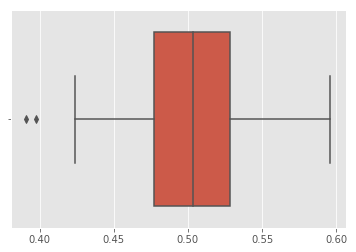

In [4]:
# ### Pre-test Agent
print('Baselining untrained pnet...', flush=True)
rwd_mg0 = []
for k in range(num_episodes):
    embrf.play(sess)
    rwd_mg0.append(float(embrf.last_total_return)/embrf.max_episode_length)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
base_perf_mg = np.mean(rwd_mg0)
print("\nAgent wins an average of {} pct".format(100.0*base_perf_mg), flush=True)

sns.boxplot(rwd_mg0)

In [5]:
# ### Train Agent w/ Algo on Experience Tuples
# Train pnet on mingame episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
embrf.work(sess, saver, num_epochs=n_epochs)  # n_epochs)

Training...
Starting agent mgRF
Epoch no.: 0/1001
Step 0: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [72.0, -0.6930598, 0.69313437] )
Saved Model
Epoch no.: 500/1001
Step 500: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [83.0, -0.69532406, 0.69282347] )
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Saved Model
Epoch no.: 1000/1001
Step 1000: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [81.0, -0.6928066, 0.69311506] )
Saved Model


In [7]:
# ### Post-test Agent# Test pnet!
print('Testing...', flush=True)
rwd_mg = []
for k in range(num_episodes):
    embrf.play(sess)
    rwd_mg.append(float(embrf.last_total_return)/embrf.max_episode_length)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
trained_perf_mg = np.mean(rwd_mg)
print("\nAgent wins an average of {} pct \ncompared to baseline of {} pct".format(
    100*trained_perf_mg, 100*base_perf_mg), flush=True )

Testing...
Episode 120/150
Agent wins an average of 50.984547461368656 pct 
compared to baseline of 50.34437086092716 pct


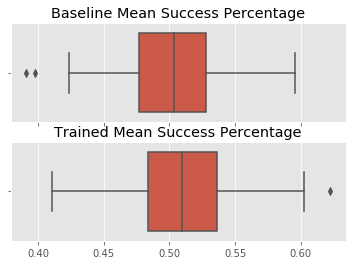

In [8]:
import seaborn as sns
fig, axs = plt.subplots(2, 1, sharex=True)
sns.boxplot(rwd_mg0, ax = axs[0])
axs[0].set_title('Baseline Mean Success Percentage')
sns.boxplot(rwd_mg, ax = axs[1])
axs[1].set_title('Trained Mean Success Percentage')

sess.close()

(array([ 5.,  3., 18., 22., 32., 43., 13.,  8.,  1.,  5.]),
 array([0.41059603, 0.43178808, 0.45298013, 0.47417219, 0.49536424,
        0.51655629, 0.53774834, 0.5589404 , 0.58013245, 0.6013245 ,
        0.62251656]),
 <a list of 10 Patch objects>)

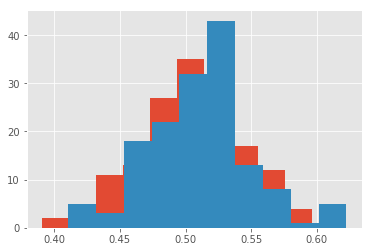

In [9]:
plt.hist(rwd_mg0)
plt.hist(rwd_mg)

In [19]:
from scipy.stats import bernoulli
bernoulli.rvs(0.5, size=10)

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0])